In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch

import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils
from torchvision.transforms import Resize, ToTensor, Normalize
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

In [2]:
train_path = '/opt/ml/input/data/train'
train_image_dir_path = os.path.join(train_path, 'images')

In [3]:
def search(dirname, result):
    try:
        filenames = os.listdir(dirname)
        for filename in filenames:
            if filename[0] == ".":
                continue
            full_filename = os.path.join(dirname, filename)
            if os.path.isdir(full_filename):
                search(full_filename, result)
            else:
                ext = os.path.splitext(full_filename)[-1]
                if ext:
                    result.append(full_filename)
    except PermissionError:
        pass

In [4]:
all_path = []
search(train_image_dir_path, all_path)

In [5]:
len(all_path)

18900

In [6]:
all_path[:10]

['/opt/ml/input/data/train/images/006730_male_Asian_19/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/006730_male_Asian_19/mask5.jpg',
 '/opt/ml/input/data/train/images/006730_male_Asian_19/normal.jpg',
 '/opt/ml/input/data/train/images/006730_male_Asian_19/mask4.jpg',
 '/opt/ml/input/data/train/images/006730_male_Asian_19/mask3.jpg',
 '/opt/ml/input/data/train/images/006730_male_Asian_19/mask2.jpg',
 '/opt/ml/input/data/train/images/006730_male_Asian_19/mask1.jpg',
 '/opt/ml/input/data/train/images/006959_male_Asian_19/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/006959_male_Asian_19/mask5.jpg',
 '/opt/ml/input/data/train/images/006959_male_Asian_19/normal.jpg']

In [7]:
exts = []
for i in all_path:
    ext = os.path.splitext(i)[-1]
    if ext not in exts:
        exts.append(ext)
print(exts)

['.jpg', '.jpeg', '.png']


In [8]:
all_path = sorted(all_path)

In [9]:
def labeling(name):
    label = 0
    info, mask_type = name.split('/')[-2:]
    info = info.split('_')
    gender, age = info[1], int(info[3])
    if 'incorrect' in mask_type:
        label += 6
    elif 'normal' in mask_type:
        label += 3
    
    if gender == 'female':
        label += 3
    if 30 <= age and age < 60:
        label += 1
    elif age >= 60:
        label +=2
    return label

In [11]:
train_path_label = pd.DataFrame(all_path, columns = ['path'])
train_path_label['label'] = train_path_label_df['path'].map(lambda x : labeling(x))
train_path_label

,path,label
0,/opt/ml/input/data/train/images/000001_female_...,10
1,/opt/ml/input/data/train/images/000001_female_...,4
2,/opt/ml/input/data/train/images/000001_female_...,4
3,/opt/ml/input/data/train/images/000001_female_...,4
4,/opt/ml/input/data/train/images/000001_female_...,4
...,...,...
18895,/opt/ml/input/data/train/images/006959_male_As...,0
18896,/opt/ml/input/data/train/images/006959_male_As...,0
18897,/opt/ml/input/data/train/images/006959_male_As...,0
18898,/opt/ml/input/data/train/images/006959_male_As...,0


In [12]:
class CustomDataset(Dataset):
    def __init__(self, img_paths_label, transform):
        self.x = img_paths_label['path']
        self.y = img_paths_label['label']
        self.transform = transform
    def __getitem__(self, index):
        image = Image.open(self.x.iloc[index])
        label = self.y.iloc[index]
        
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)
    
    def __len__(self):
        return len(self.x)

In [13]:
transform = transforms.Compose([
    Resize((512,384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean = (0.5,0.5,0.5), std = (0.2,0.2,0.2)),])

In [14]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(train_path_label, 
                                test_size = 0.2,
                                shuffle = True,
                                stratify = train_path_label['label'],
                                random_state = 34)

In [15]:
train.shape, valid.shape

((15120, 2), (3780, 2))

In [16]:
BATCH_SIZE = 64

In [17]:
train_dataset = CustomDataset(train, transform)
train_dataloader = DataLoader(train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

In [18]:
valid_dataset = CustomDataset(valid, transform)
valid_dataloader = DataLoader(valid_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

In [19]:
next(iter(train_dataloader))[0].shape

torch.Size([64, 3, 512, 384])

In [20]:
resnet18 = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /opt/ml/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [24]:
import math
OUTPUT_CLASS_NUM = 18
resnet18.fc = torch.nn.Linear(in_features = 512, out_features = OUTPUT_CLASS_NUM, bias = True)
torch.nn.init.xavier_uniform_(resnet18.fc.weight)
stdv = 1. / math.sqrt(resnet18.fc.weight.size(1))
resnet18.fc.bias.data.uniform_(-stdv, stdv)

resnet18.fc.weight.shape[0]

18

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [26]:
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
LEARNING_RATE = 0.0001
NUM_EPOCH = 5
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr = LEARNING_RATE)

dataloaders = {
    "train" : train_dataloader,
    "test" : valid_dataloader}

In [34]:
best_test_accuracy = 0.
best_test_loss = 9999.

for epoch in range(NUM_EPOCH):
    for phase in ["train", "test"]:
        running_loss = 0
        running_acc = 0
        if phase == "train":
            resnet18.train()
        elif phase == "test":
            resnet18.eval()
        for ind, (images, labels) in enumerate(dataloaders[phase]):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == "train"):
                logits = resnet18(images)
                _, preds = torch.max(logits, 1)
                loss = loss_fn(logits, labels)
                
                if phase == "train":
                    loss.backward()
                    optimizer.step()
            running_loss += loss.item() * images.size(0)
            running_acc += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_acc / len(dataloaders[phase].dataset)
        
        print(f"현재 epoch-{epoch}의 {phase}-데이터 셋에서 평균 Loss : {epoch_loss:.3f}, 평균 Accuracy : {epoch_acc:.3f}")
        if phase == "test" and best_test_accuracy < epoch_acc:
            best_test_accuracy = epoch_acc
        if phase == "test" and best_test_loss > epoch_loss:
            best_test_loss = epoch_loss
print("학습 종료!")
print(f"최고 accuracy : {best_test_accuracy}, 최고 낮은 loss : {best_test_loss}")

현재 epoch-0의 train-데이터 셋에서 평균 Loss : 0.026, 평균 Accuracy : 0.995
현재 epoch-0의 test-데이터 셋에서 평균 Loss : 0.257, 평균 Accuracy : 0.905
현재 epoch-1의 train-데이터 셋에서 평균 Loss : 0.015, 평균 Accuracy : 0.998
현재 epoch-1의 test-데이터 셋에서 평균 Loss : 0.119, 평균 Accuracy : 0.965
현재 epoch-2의 train-데이터 셋에서 평균 Loss : 0.006, 평균 Accuracy : 0.999
현재 epoch-2의 test-데이터 셋에서 평균 Loss : 0.080, 평균 Accuracy : 0.979
현재 epoch-3의 train-데이터 셋에서 평균 Loss : 0.012, 평균 Accuracy : 0.997
현재 epoch-3의 test-데이터 셋에서 평균 Loss : 0.089, 평균 Accuracy : 0.975
현재 epoch-4의 train-데이터 셋에서 평균 Loss : 0.020, 평균 Accuracy : 0.994
현재 epoch-4의 test-데이터 셋에서 평균 Loss : 0.129, 평균 Accuracy : 0.958
학습 종료!
최고 accuracy : 0.9788359999656677, 최고 낮은 loss : 0.07988095300459357


In [38]:
def func_eval(model, data_iter, device):
    with torch.no_grad():
        n_total, n_correct = 0,0
        model.eval()
        for batch_in, batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model.forward(batch_in.to(device))
            _, y_pred = torch.max(model_pred, 1)
            n_correct += (y_pred == y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
    return val_accr

In [39]:
func_eval(resnet18, valid_dataloader, device)

0.9582010582010582

In [44]:
def check_eval(raw_data, dataloader, model, device):
    result = []
    with torch.no_grad():
        model.eval()
        for i, (X,y) in enumerate(dataloader):
            model_pred = model.forward(X.to(device))
            _, y_pred = torch.max(model_pred,1)
            
            result.append([valid.iloc[i]['path'], y_pred.cpu().numpy()[0], y.cpu().numpy()[0]])
    result = pd.DataFrame(result, columns = ['path','pred','target'])
    return result

In [45]:
valid_testing_dataloader = DataLoader(valid_dataset, shuffle = False)
check_eval_df = check_eval(valid, valid_testing_dataloader, resnet18, device)
check_eval_df

,path,pred,target
0,/opt/ml/input/data/train/images/001482_female_...,8,8
1,/opt/ml/input/data/train/images/000573_female_...,4,4
2,/opt/ml/input/data/train/images/001028_female_...,9,9
3,/opt/ml/input/data/train/images/000619_female_...,4,4
4,/opt/ml/input/data/train/images/003380_female_...,3,3
...,...,...,...
3775,/opt/ml/input/data/train/images/003119_female_...,3,3
3776,/opt/ml/input/data/train/images/001488_female_...,10,10
3777,/opt/ml/input/data/train/images/004476_female_...,4,5
3778,/opt/ml/input/data/train/images/000001_female_...,7,7


In [48]:
wrong_df = check_eval_df[check_eval_df['pred'] != check_eval_df['target']]
wrong_df = wrong_df.reset_index(drop=True)
wrong_df

,path,pred,target
0,/opt/ml/input/data/train/images/003701_male_As...,1,2
1,/opt/ml/input/data/train/images/005223_male_As...,6,3
2,/opt/ml/input/data/train/images/006360_female_...,3,6
3,/opt/ml/input/data/train/images/005451_male_As...,0,1
4,/opt/ml/input/data/train/images/005451_male_As...,3,4
...,...,...,...
153,/opt/ml/input/data/train/images/001769_male_As...,4,1
154,/opt/ml/input/data/train/images/000225_female_...,6,9
155,/opt/ml/input/data/train/images/001064_female_...,6,7
156,/opt/ml/input/data/train/images/003712_male_As...,1,2


In [49]:
def draw_(df):
    plt.figure(figsize = (15,30))
    row = 7
    for i in range(df.shape[0]):
        plt.subplot(row + 1, df.shape[0]//row, i+1)
        plt.imshow(Image.open(df['path'][i]))
        plt.title(f"target:{df['target'][i]}, pred:{df['pred'][i]}", color = 'r',size = 20)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

<ipython-input-49-cedcef795769>:9: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


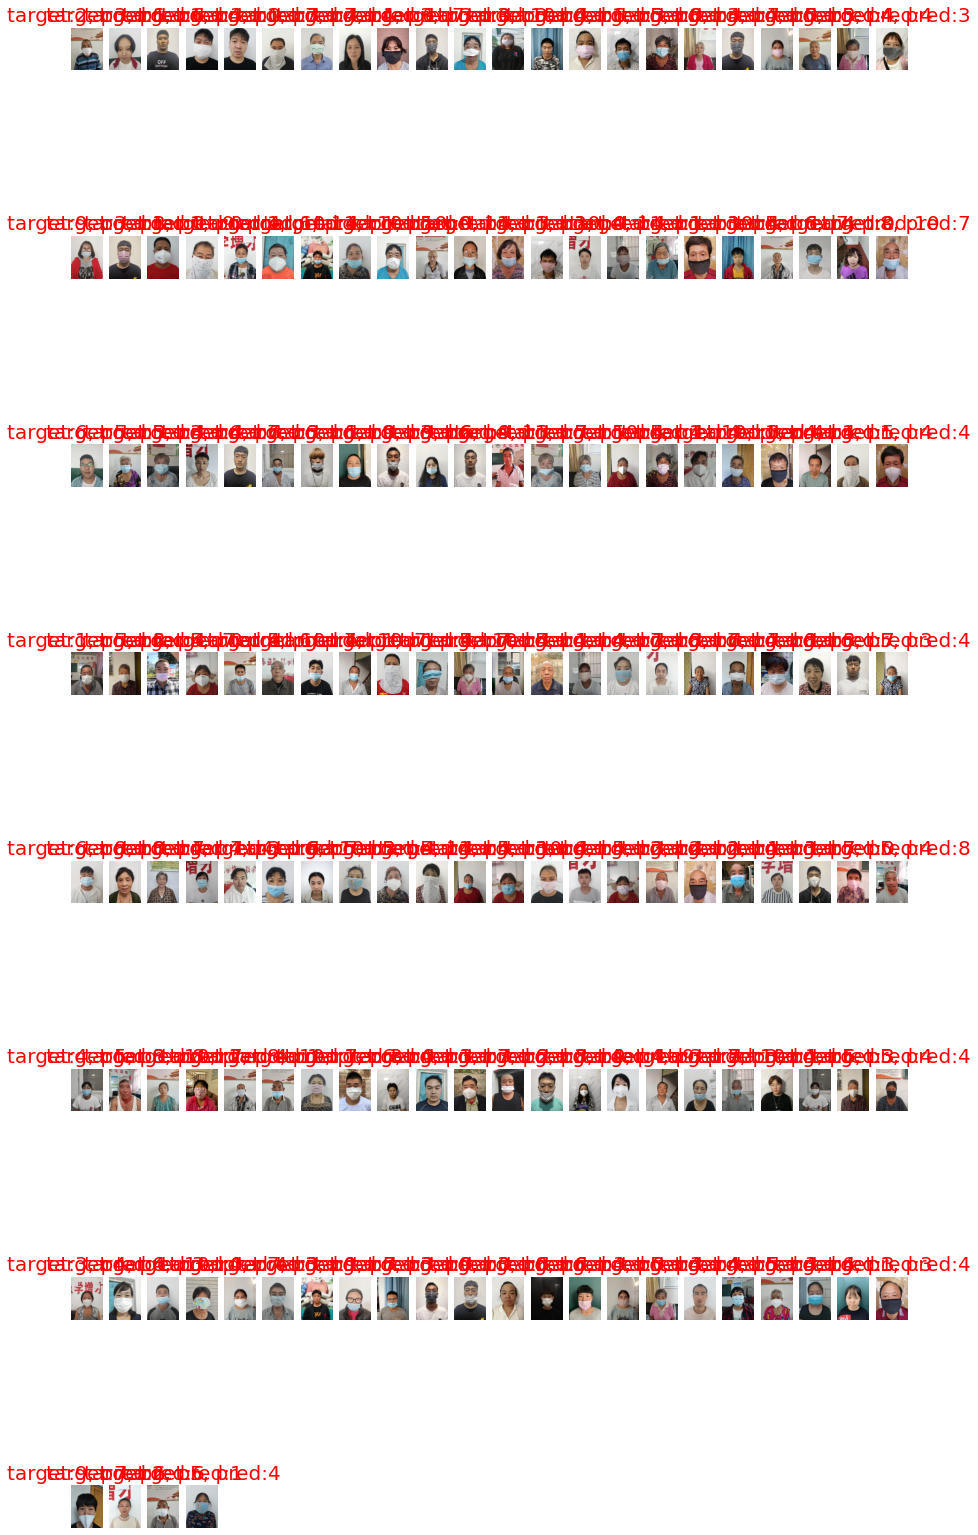

In [50]:
draw_(wrong_df)

In [52]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
f1_score(check_eval_df['target'], check_eval_df['pred'], average='macro')

0.932776328885662